# Protein Folding with Intermediates

## Deterministic equations

A general set of chemical reactions can be described by the stoichiometry matrices $R$ and $P$ as:
\begin{equation}
\sum_i R_{\mu i} S_i \xrightarrow{k_u} \sum_j P_{\mu j} s_j
\end{equation}
The general rate equations are:
\begin{equation}
\frac{dN_i}{dt} = \sum_\mu v_\mu Q_{\mu i}
\end{equation}
where $Q \equiv P - R$ is the net stoichiometry matrix and $v_\mu$ is the reaction rate that we have calculated for stochastic simulations:
\begin{equation}
v_\mu = k_\mu \prod_i N_i^{R_{\mu i}}
\end{equation}

Here is a general purpose class for solving rate equations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as intgr

In [2]:
class RateEquations:
    """
    solve rate equations numerically, assuming mass action kinetics.
    """
    
    def __init__(self, stoich, rates, init, record=True):
        """
        initialize solver by assigning stoichiometry matrices, rate constants, and initial values.
        inputs:
        stoich: 2-tuple, stoichiometry matrices of reactants and products, (R_ui, P_ui), u = 1 ~ m, i = 1 ~ n
        rates: list, rate parameters, K_u, u = 1 ~ M
        init: list, initial numbers of every species, N_i(0), i = 1 ~ n
        record: boolean, whether to record numbers of species at time points
        """
        self.reactants = np.asarray(stoich[0])    # stoichiometry matrices of reactants
        self.products = np.asarray(stoich[1])    # stoichiometry matrices of products
        self.rates = np.asarray(rates, dtype=float)    # reaction rates
        self.numbers = np.asarray(init, dtype=float)    # current numbers of each species, treat as real numbers

        self.num_reac = self.reactants.shape[0]    # number of reactions
        self.num_spec = self.reactants.shape[1]    # number of species

        self.time = 0.                  # time since beginning of simulation
        self.record = record            # whether to record time series

        if self.record:
            self.time_hist = [0.]                  # list of time points
            self.numbers_hist = [self.numbers.copy()]     # list of species numbers at time points
    
    
    def run(self, tmax, dt):
        """
        solve rate equations until time `tmax` since the beginning.
        inputs:
        tmax: float, time since the beginning of the simulation.
        dt: float, time step by which solution is calculated
        """
        T = tmax - self.time    # time remaining to be solved
        new_times = np.arange(0, T+dt, dt)    # new time points at every step dt
        x0 = self.numbers    # current species numbers as initial values to the solver
        sol = intgr.odeint(self.mass_action, x0, new_times)    # solve equations using integrator
        if self.record:
            self.time_hist.extend(self.time + new_times[1:])    # save time points
            self.numbers_hist.extend(sol[1:])    # save species numbers at given time points
        self.time += new_times[-1]    # update time to latest
        self.numbers = sol[-1]    # update species numbers to latest
        
    
    def mass_action(self, x, t):
        """
        calculate time derivative of species numbers using mass action kinetics.
        inputs:
        x: 1-d array, current numbers of every species, treat as real numbers.
        t: float, current time.
        outputs:
        dxdt: 1-d array, time derivatives of species numbers.
        """
        r_u = self.rates * np.prod(np.power(x, self.reactants), axis=1)    # rates of every reaction
        Q_ui = self.products - self.reactants    # net stoichiometry matrix
        dn_i = np.dot(r_u, Q_ui)    # time derivatives of species numbers
        return dn_i


## Folding-unfolding model

Let us first test this `RateEquations` class on the simple folding-unfolding model we solved last time:
\begin{align*}
U \xrightarrow{k_f} F \\
F \xrightarrow{k_u} U
\end{align*}

Now we can define a derived class for our problem by specifying the stoichiometry matrices, like what we did for stochastic simulations.

In [3]:
class FoldingUnfolding2(RateEquations):
    """
    define a derived class to model the folding and unfolding of proteins.
    """
    
    def __init__(self, rates, init, record=True):    # decorate base method
        """
        modify the initialization to specify the stoichiometry matrices.
        the chemical species are U and F in that order; the reactions are U -> F and F -> U.
        """
        reactants = [[1, 0],
                     [0, 1]]
        products = [[0, 1],
                    [1, 0]]
        RateEquations.__init__(self, (reactants, products), rates, init, record=record)

In [4]:
kf = 9.    # folding rate
ku = 1.    # unfolding rate

NU0 = 100    # initial number of unfolded proteins
NF0 = 0    # initial number of folded proteins
N_tot = NU0 + NF0    # total number of proteins

K = kf / ku    # equilibrium constant
NUeq = 1/(1+K) * N_tot    # equilibrium number of unfolded proteins
NFeq = K/(1+K) * N_tot    # equilibrium number of folded proteins

In [5]:
T = 1.0
dt = 0.01

fu2 = FoldingUnfolding2([kf, ku], [NU0, NF0])
fu2.run(T, dt)
sol = np.array(fu2.numbers_hist)

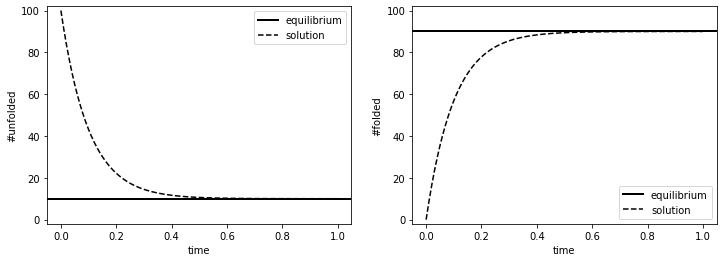

In [6]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].axhline(NUeq, color='k', linewidth=2, label='equilibrium')    # expected number at equilibrium
ax[1].axhline(NFeq, color='k', linewidth=2, label='equilibrium')    # expected number at equilibrium
ax[0].plot(fu2.time_hist, sol[:,0], 'k--', label='solution')    # solution to the rate equations
ax[1].plot(fu2.time_hist, sol[:,1], 'k--', label='solution')    # solution to the rate equations
ax[0].set_ylim(-2, 102)
ax[0].set_xlabel('time')
ax[0].set_ylabel('#unfolded')
ax[0].legend(loc='upper right')
ax[1].set_ylim(-2, 102)
ax[1].set_xlabel('time')
ax[1].set_ylabel('#folded')
ax[1].legend(loc='lower right')
plt.show()

## Folding-unfolding with an intermediate

Let us consider a slightly more complicated model of protein folding, where the transition from the unfolded state to the folded state has to go through an intermediate state that is metastable. Denote the intermediate state by $M$, then there will be four reactions:
\begin{align}
U \xrightarrow{k_m} M \\
M \xrightarrow{k_f} F \\
F \xrightarrow{k_d} M \\
M \xrightarrow{k_u} U
\end{align}

### **Exercise**: solve the extended model using rate equations.

In [ ]:
km = 9.    # folding rate of intermediate
ku = 1.    # unfolding rate of intermediate
kf = 3.    # folding rate of final state
kd = 0.3    # unfolding rate of final state

NU0 = 100    # initial number of unfolded proteins
NF0 = 0    # initial number of folded proteins
NM0 = 0    # initial number of intermediate state
N_tot = NU0 + NF0 + NM0    # total number of proteins

In [ ]:
class FoldingUnfoldingWithIntermediate(RateEquations):
    """
    define a derived class to model the folding and unfolding of proteins.
    """
    
    def __init__(self, rates, init, record=True):    # decorate base method
        """
        modify the initialization to specify the stoichiometry matrices.
        the chemical species are U and F in that order; the reactions are U -> F and F -> U.
        """
        reactants = ...
        products = ...
        RateEquations.__init__(self, (reactants, products), rates, init, record=record)

In [ ]:
T = 2.0
dt = 0.01

fu2 = ...

In [ ]:
time_hist = np.array(fu2.time_hist)
num_hist = np.array(fu2.numbers_hist)

fig, ax = plt.subplots(1,3, figsize=(18,4))
for i in range(3):
    ax[i].plot(time_hist, num_hist[:,i], 'k--', label='solution')    # solution to the rate equations
    ax[i].set_ylim(-2, 102)
    ax[i].set_xlabel('time')
    ax[i].legend()
ax[0].set_ylabel('#unfolded')
ax[1].set_ylabel('#intermediate')
ax[2].set_ylabel('#folded')
plt.show()

### **Challenge**: Calculate the equilibrium numbers in terms of the rate constants and compare to numerical results

### **Solution**:

In [9]:
class FoldingUnfoldingWithIntermediate(RateEquations):
    """
    define a derived class to model the folding and unfolding of proteins.
    """
    
    def __init__(self, rates, init, record=True):    # decorate base method
        """
        modify the initialization to specify the stoichiometry matrices.
        the chemical species are U and F in that order; the reactions are U -> F and F -> U.
        """
        reactants = [[1, 0, 0],
                     [0, 1, 0],
                     [0, 0, 1],
                     [0, 1, 0]]
        products = [[0, 1, 0],
                    [0, 0, 1],
                    [0, 1, 0], 
                    [1, 0, 0]]
        RateEquations.__init__(self, (reactants, products), rates, init, record=record)

In [12]:
T = 2.0   # total amount of time to solve
dt = 0.01    # time step by which the solutions are recorded

fu2 = FoldingUnfoldingWithIntermediate([km, kf, kd, ku], [NU0, NM0, NF0])
fu2.run(T, dt)

In [ ]:
K1 = kf / kd
K2 = ku / km
NUeq = K2 / (1 + K1 + K2) * N_tot    # equilibrium number of unfolded proteins
NMeq = 1 / (1 + K1 + K2) * N_tot    # equilibrium number of intermediates
NFeq = K1 / (1 + K1 + K2) * N_tot    # equilibrium number of folded proteins

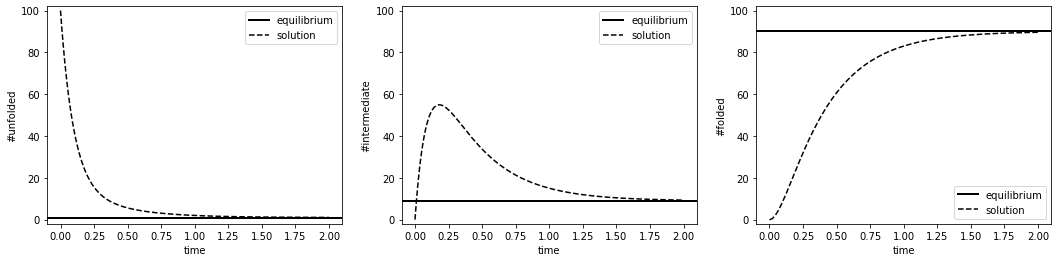

In [14]:
time_hist = np.array(fu2.time_hist)
num_hist = np.array(fu2.numbers_hist)

fig, ax = plt.subplots(1,3, figsize=(18,4))
ax[0].axhline(NUeq, color='k', linewidth=2, label='equilibrium')    # expected number at equilibrium
ax[1].axhline(NMeq, color='k', linewidth=2, label='equilibrium')    # expected number at equilibrium
ax[2].axhline(NFeq, color='k', linewidth=2, label='equilibrium')    # expected number at equilibrium
for i in range(3):
    ax[i].plot(time_hist, num_hist[:,i], 'k--', label='solution')    # solution to the rate equations
    ax[i].set_ylim(-2, 102)
    ax[i].set_xlabel('time')
    ax[i].legend()
ax[0].set_ylabel('#unfolded')
ax[1].set_ylabel('#intermediate')
ax[2].set_ylabel('#folded')
plt.show()